***
<img style="float: right;" src="img/uc-vert-rgb-small.jpg">

# MDGE 610 Bioinformatics Session 2
# A Gentle Introduction to Probability Modelling

Jason de Koning, Ph.D., <jdekonin@ucalgary.ca>

**January 11, 2023**


***

### Objectives:

This week we'll make sure everyone is comfortable working in `R`. The entirety of the exercise today will be performed using `R` and important functionality of the language is reviewed. Specific sub-objectives for this week include:
* Introduce modelling concepts
* First probability model with coin flipping
* Simulate outcomes as a way to examine experimental design
* Introduce maximum likelihood and likelihood ratios

### Graded component:
* Responses to labelled questions (indicated with big question mark)
* Assignments are due in 1 week (before class)

### Other notes:
* In code samples **tips** are indicated with double hash marks
* To run these notebooks you'll need to install [Anaconda](http://https://www.anaconda.com/download/) and [IRKernel](<https://irkernel.github.io/installation/)

### Email submissions before next Monday's class to <MDSC-679@jasondk.org>

***
## Readings:
#### For the next session (Jan. 15):
- Probability review (if needed): Bishop, pp. 12-20
- ["Big Data: Astronomical or Genomical?"](http://www.plosbiology.org/article/fetchObject.action?uri=info:doi/10.1371/journal.pbio.1002195&representation=PDF) (Stephens et al., 2015)
- [“The more-the-better and the less-the-better”](http://bioinformatics.oxfordjournals.org/content/22/18/2187.full)  (Wentian Li, 2006) 

#### For Monday's session (Jan. 18):
- [“Statistical modelling: the two cultures”](http://projecteuclid.org/euclid.ss/1009213726) (Leo Breiman, 2001)
- (OPTIONAL) ["The unreasonable effectiveness of data"](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf) (Halevy et al., 2009)



***

# Table of Contents

**[1. Modelling concepts](#s1)**
* [1.1 What good are models?](#s11)
* [1.2 Determinisitic versus probabilistic models](#s12)
* [1.3 Advice on building models](#s13)

**[2. Random number generation and simulation](#s2)**
* [2.1 Pseudo-random numbers](#s21)
* [2.2 Uniform random variates](#s22)
* [2.3 Non-uniform random variates](#s23)

**[3. Using predictive simulation to understand experimental design](#s3)**

**[4. Likelihood approaches](#s4)**
* [4.1. Obtaining maximum likelihood solutions](#s41)
* [4.2. Grid-search exercise](#s42)
* [4.3. Numerical optimization for MLE](#s43)
* [4.4. Likelihood ratios](#s44)


---

# 1. Modelling Concepts <a id='s1'></a>

### 1.1. What good are models?<a id='s11'></a>

Models formalize what we think we know about natural systems and processes. The function of models is to strip away unnecessary detail with respect to a particular behaviour of interest. This allows quantitative predictions to be made, which can then be tested by experimental or rational challenge.

At the simplest levels, models specify how some input is transformed to an output/s.

![blackbox](img/Model-BlackBox.jpg)

In this black box example, our model has a vector of parameters $\theta$, which can be thought of as knobs that can be played with to change how inputs $X$ are mapped to outputs $f(X|\theta)$.

Models can be described along different continuums. One important dimension relates to whether a model is **mechanistic** or **phenomenological**. The goal of a mechanistic model is to capture causality as directly as possible, with reference to underlying parameters and quantities that may be directly observed, discerned through experiment, or **interpreted with respect to the data generating mechanism**. Phenomenological models more simply seek to explain patterns in the data, perhaps as assessed by statistical criteria such as goodness-of-fit. As a result of this focus on ends rather than means, phenomenological models can be harder to interpret in relation to underlying processes.

In bioinformatics, as in most scientific fields, mechanistic models are usually the preferred end-product. However, in many cases a phenomenological model is good enough. For example, if we only need a model to provide predictions or classifications, it may not be of primary interest how those predictions were generated, so long as they are correct. Such scenarios motivate machine learning approaches, which tend to focus on fast, approximate, and phenomenological explanations of data.

Machine learning and statistics are sometimes described as the "two cultures" in data-focused sciences such as bioinformatics. As statistical modelling is typically focused on understanding mechanisms using data, it is more closely connected to scientific inquiry than is machine learning. There are many views on the relative merits of each approach, and indeed there is much common ground. For a well articulated but machine-learning biased perspective and some interesting follow-up commentary and discussion, I recommend reading Leo Breiman's (2001) ["Statistical modelling: the two cultures"](http://projecteuclid.org/euclid.ss/1009213726). 


### 1.2. Deterministic versus probabilistic models<a id='s12'></a>

An important distinction among kinds of models is whether they are **deterministic** or **stochastic** (or probabilistic). In deterministic models, the output is fully determined by the parameter values of the model (and potentially some initial conditions).

**Note:** Jupyter notebooks embed live code. To follow the examples (and do the assignment) you'll need to execute the code in each block *sequentially*. This becomes important later, so get in the habit of clicking on the code box and running the example code with SHIFT-ENTER. If you encounter unfamiliar commands or concepts, you should try modifying the code to see what happens.

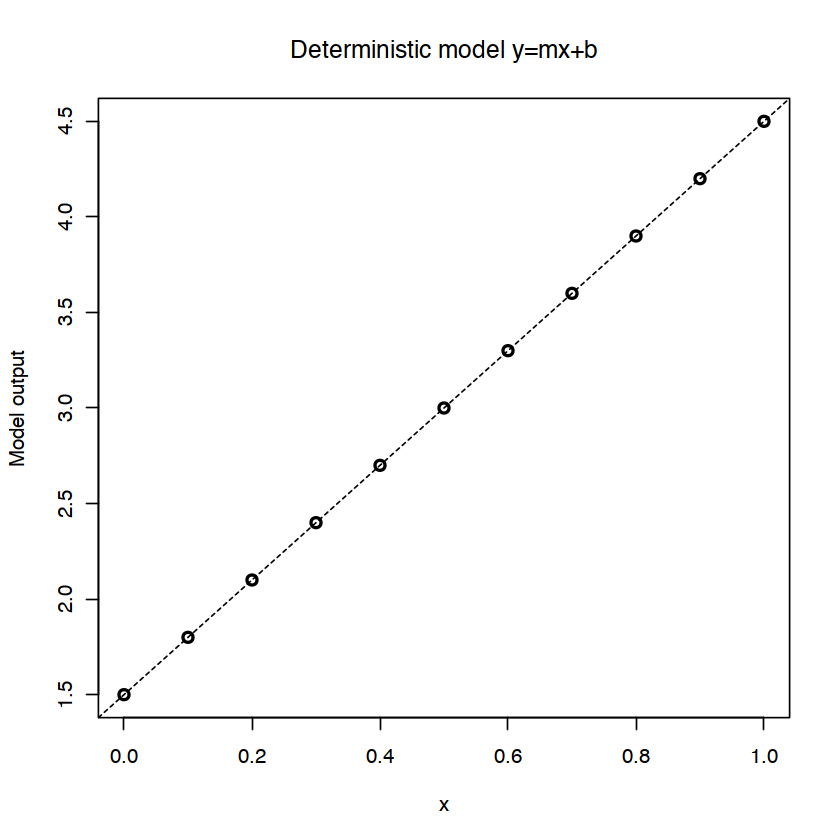

In [1]:
# A simple deterministic model
initial = 1.5;
slope = 3.0;
x = seq( 0, 1, 0.1 );

# This is the 'model'
y = slope * x + initial;

plot(x,y, type='p', main='Deterministic model y=mx+b', ylab='Model output', lwd=2);
abline( a = initial, b = slope, lty='dashed', lwd=1 );

In stochastic models, the output can possess some inherent randomness. This randomness can reflect:
* sampling error (properties of the sample of the population you happend to obtain)
* measurement error
* cryptic variation between unknown groups
* some fundamental uncertainty

or all of these. 

For example, for a simple linear model we can add an error term and specify that we believe that errors (deviations from our model) are [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution). This error term is an example of a [random variable](https://en.wikipedia.org/wiki/Random_variable). Standard notation is to write $\epsilon \sim \mathcal{N}(\mu, \sigma^2)$, which is read "`epsilon is distributed as`". 

For this simple model, if we call the initial value (or intercept) $\alpha$ and the slope $\beta$, we can then write:

$$\left \{ \begin{align}
y &\sim \beta X + \alpha + \epsilon \\
\epsilon &\sim \mathcal{N}( 0, \sigma )
\end{align} \right.$$

where quantities without distributional assumptions are assumed to not be random variables (e.g., $\beta, \alpha$).

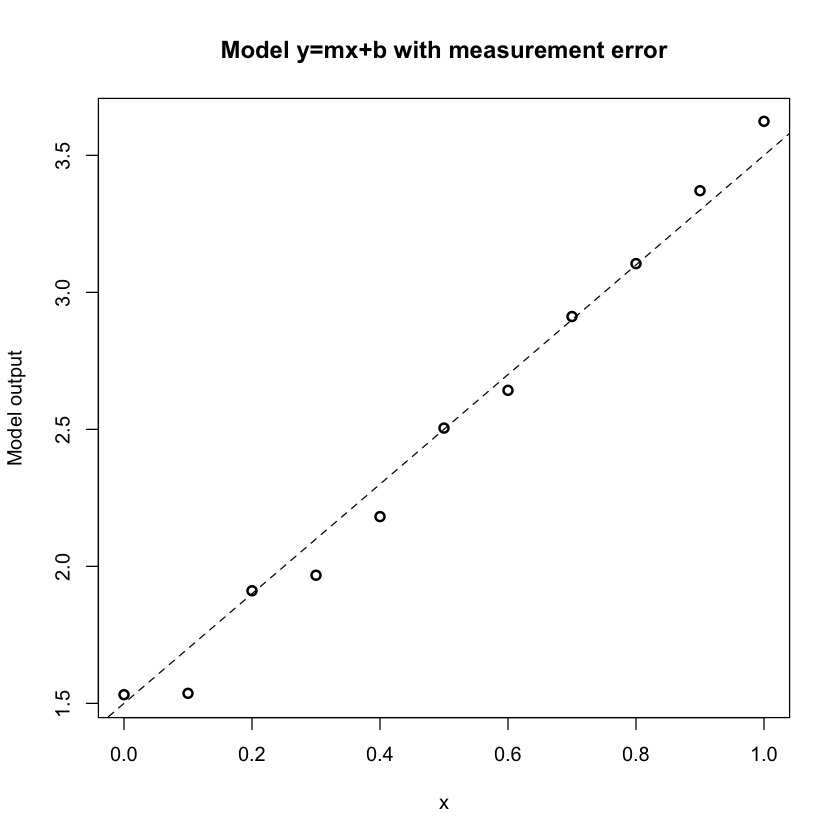

In [53]:
# A simple model with measurement error
sigma = 0.1;

initial = 1.5;
slope = 2.0;
x = seq( 0, 1, 0.1 );

# This is the model
## rnorm() draws random variates from a normal distribution
y = (slope * x + initial) + rnorm( n = length(x), mean = 0, sd = sigma ) ;

plot(x,y, type='p', main='Model y=mx+b with measurement error', ylab='Model output', lwd=2);
abline( a=initial, b=slope, lty='dashed', lwd=1 );

It is common in applied bioinformatics to build models that include multiple sources of error and to try to estimate components of this error in large data. Note, we will deal with how to perform parameter estimation (statistical inference) later on. For example, in microarray analysis of gene expression, typically the hybridization intensity, $I$, would be assumed to depend upon the RNA transcript abundance, $\theta$, plus some error term:

$$I(i,j) = f_j(\theta_i) + \epsilon(i,j)$$

In these sorts of models, the error term is often decomposed into a set of contributions from different sources [(Weng et al., 2006)](http://bioinformatics.oxfordjournals.org/content/22/9/1111.long),

$$
\epsilon(i,j) = \epsilon_\text{add}(i,j) + \epsilon_\text{Poisson}(i,j) + \epsilon_\text{frac}(i,j) + \epsilon_\text{spot}(i,j)
$$

This is typically done because reasonable assumptions can be made about several such sources of error and often aspects of each can be independently measured.

### 1.3. Advice on building models<a id='s13'></a>

Designing and building models can be a daunting task. On a basic level, building models is closely allied to problem solving. Thus a great starting point is Polya's classic mini-text on problem solving, "How to solve it". The best advice when building a model is to have a clear idea of what you are trying to understand.

Throughout this course we will consider some of the ways to evaluate models and to determine if a model is "good". Some of these approaches include matching **predictive data distributions** (i.e., data *simulated* under your model) with observations, and formal **model selection**. Sometimes the ideal choice will be to make no choice at all - when the model itself is uncertain, as it often is, a set of candidate models can be considered together. Model averaging is a statistical technique that weighs the importance of each model in a set by its posterior probability. Ensemble methods in machine learning take a similar approach.

For general background on how to go about building models, see:

* Otto and Day, 2007. A Biologist's Guide to Mathematical Modelling in Ecology and Evolution. Chapter 2.
* Pólya, 1945. ["How to solve it".](https://en.wikipedia.org/wiki/How_to_Solve_It)

A generally good resource on model selection is:

* Burnham and Anderson, 2002. Model selection and multi-model inference.


***
## 2. Random numbers and simulation <a id='s2'></a>

### 2.1 Pseudorandom numbers <a id='s21'></a>

Before we delve into the world of stochastic models, we will take a brief detour to examine random number generation (RNG). RNG is an essential component of computational statistics, especially for its role in simulation. There are two types of random numbers in the world: **random (true) random** and **pseudo-random**. Some computers actually have [hardware units](https://en.wikipedia.org/wiki/Hardware_random_number_generator) that try to use thermal noise from the environment as a source of entropy with which to generate true random numbers. However, most random number generators actually deal with pseudo-random methods.

### 2.2. Uniform random variates  <a id='s22'></a>

[Pseudo-random number generators (PRNG)](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) work by several methods typically to generate **uniformly distributed** random numbers, often between 0 and 1. Historically, most programming languages implement default PRNG methods that are rather primitive and may have short periods of repetition or require initialization with a random starting seed. **Many PRNG methods will produce identical sequences of numbers when repeated from the same starting seed.** As such, default random number generators are often inadequate for statistical simulations requiring high quality random numbers. An example of a high-quality PRNG is the famous [Mersenne twister](https://en.wikipedia.org/wiki/Mersenne_Twister), which is the default PRNG in `R`.

In `R`, a random uniform variate can be obtained using the `runif()` function. For example,

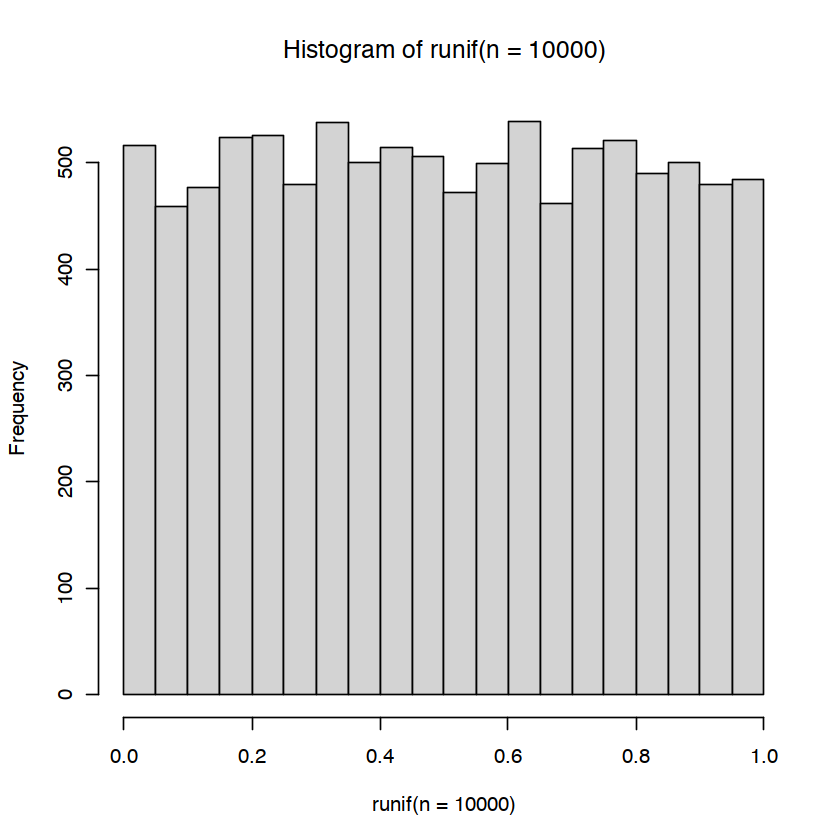

In [3]:
hist( runif( n=10000 ) );

### 2.3. Non-uniform random variates <a id='s23'></a>

As we will see below, in statistical simulations we typically need random numbers that follow a desired distribution. Most methods for generating these so-called **non-uniform random variates** take a uniform random number as their starting point. A general and transparent (but not always efficient) method for transforming uniform to non-uniform random variates, which we will consider in a subsequent week, is the **inversion method** aka [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling).

### 2.3.1. By example: the binomial distribution
A very simple example is sampling a random variate from a binomial distribution, described below. The [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) is a discrete probability distribution of the number of successes in a sequence of $n$ independent yes/no experiments, each of which yields success with probability $p$. Below, we will model coin flipping using a binomial probability model.


Consider the problem of coin flipping. We can define a **sample space** as the set of all possible outcomes. In our case, we have $S = \{ T, H \}$ for tails and heads. For a quantity to be a probability, **the probabilities taken over the entire sample space must sum to one**. If we define $p$ as the probability of flipping an $H$, we can write:

$$\begin{align}
P(H) &= p\\
P(T) &= (1-p)
\end{align}$$

from the above rule of probability. Similarly, for successive series of coin flips, we can write:

$$\begin{align}
P(H,H,T,H,T) &\propto p \cdot p \cdot (1-p) \cdot p \cdot (1-p) \\
&\propto p^3 \cdot (1-p)^2
\end{align}$$

Why is this only proportional to the full probability? Because for 5 coin flips, there are a large number of possible outcomes and the probability summed over all of those possible outcomes must equal one. We are thus missing a normalization constant to have the probability distribution function.

Because the order of the events does not matter, we can use the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), ${N \choose k}$, which gives the number of ways we could get $k$ successes in $N$ trials. With this normalization, we can now write the probability distribution for a binomial experiment from intuition

$$P(X=k) = {N \choose k} p^k (1-p)^{N-k}
$$

***
<img style="float: left; margin:0px 20px" src="img/question.jpg">
<b>Question 1:</b> Consider how you might transform a uniform random variate drawn from $u \sim U(0,1)$ to instead be distributed as $v \sim \text{Binom}(N, p)$. Note, there are many ways to do this (including a very simple one). <B>Try a few ideas now.</B> You can compare your results to `R`'s builtin function for sampling from a binomial distribution using the below example.

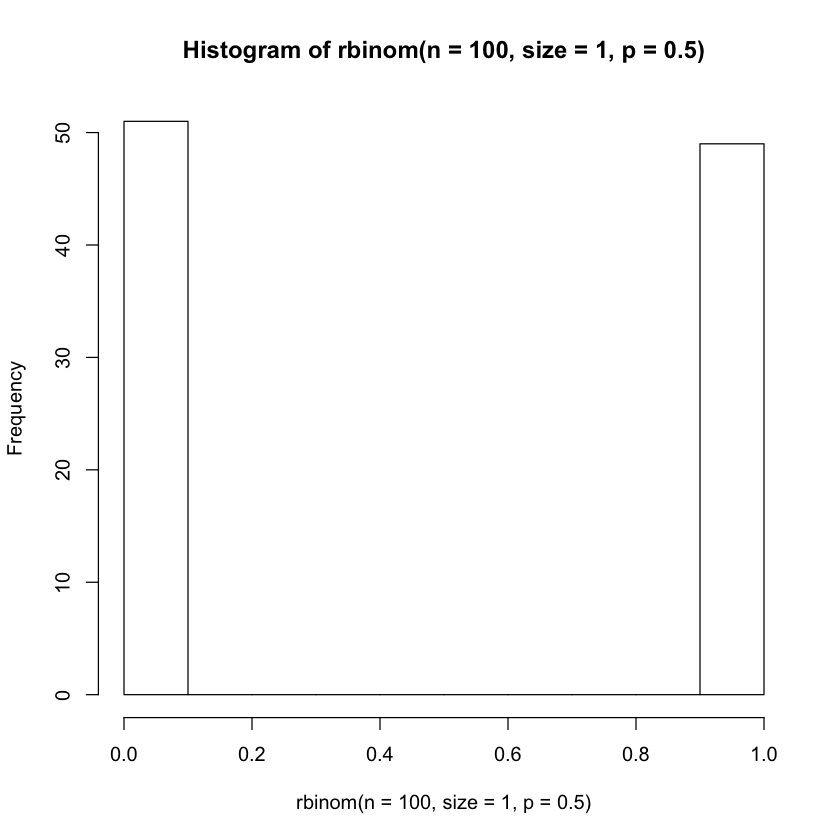

In [55]:
# Plot histogram of 100 coin flips using rbinom()
hist( rbinom( n=100, size=1, p=0.5 ) );

***
## 3. Using predictive simulation to understand experimental design <a id='s3'></a>

One of the key computational techniques for understanding probability models is simulation. Typically this entails **predictive simulation**, which means you assume some values for the model's parameters and then draw random "observations" from your model. For example, consider a hypothetical coin, which may or may not be fair (where a fair coin is one that gives equal probability to heads or tails). One way to understand expected outcomes under different values of $p$ could be to simulate a large set of outcomes for a fair coin, $X \sim \text{Binom}(n, p)$ with $p=0.5$, to a distribution of outcomes for an unfair coin, $Y \sim \text{Binom}(n,p)$ with $p \ne 0.5$.

In [4]:
# rbinom() samples from a binomial distribution
## Try ?rbinom in your R session to see help

Y <- rbinom( n=1000, size=1000, p=0.48 ); h1 <- hist(Y,plot=FALSE);
X <- rbinom( n=1000, size=1000, p=0.5  ); h2 <- hist(X,plot=FALSE);

h1

$breaks
 [1] 410 420 430 440 450 460 470 480 490 500 510 520 530 540

$counts
 [1]   1   0   0  15  84 161 248 228 159  70  31   2   1

$density
 [1] 0.0001 0.0000 0.0000 0.0015 0.0084 0.0161 0.0248 0.0228 0.0159 0.0070
[11] 0.0031 0.0002 0.0001

$mids
 [1] 415 425 435 445 455 465 475 485 495 505 515 525 535

$xname
[1] "Y"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

***
<img style="float: left; margin:0px 20px" src="img/question.jpg">
<B>Question 2:</B> Inspect the `h1` and `h2` objects. What variables do they contain? What do these correspond to? Use the help system and some experimentation to decide.

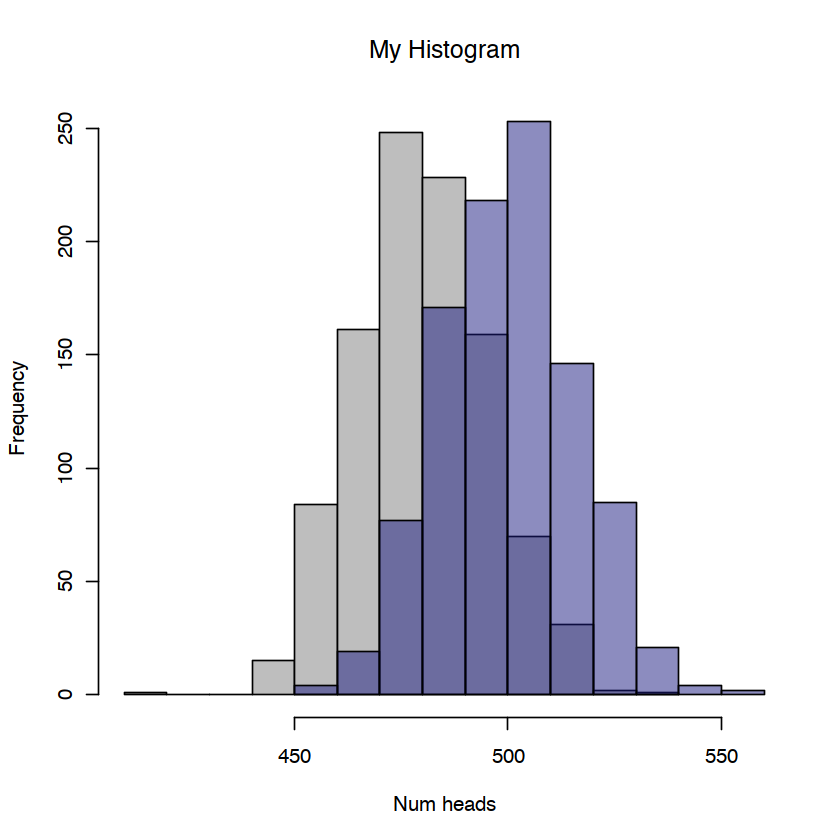

In [5]:
# Plot with axes appropriate for both datasets

## c( x1, x2, x3 ) = concatenate x1,x2,x3 together
## Min() and Max() obvious

plot( h1, xlim=c( min(h1$breaks, h2$breaks), max( h1$breaks, h2$breaks) ),
    ylim=c( min( h1$counts, h2$counts ), max( h1$counts, h2$counts ) ),
    main='My Histogram', xlab='Num heads', col='grey');

## add=TRUE is very useful, but make sure axes are set for both (or all) datasets
## Make your own colour with rgb( red, green, blue, alpha ), each value in (0,1)
plot( h2, add=TRUE, col=rgb(.1,.1,.5,.5) );

**The separation between these two distributions tells you how distinguishable the two underlying models are.** This is a property of the **experimental design**, which can be manipulated. Let's plot four histograms as above showing the identifiability of small differences in $p$.

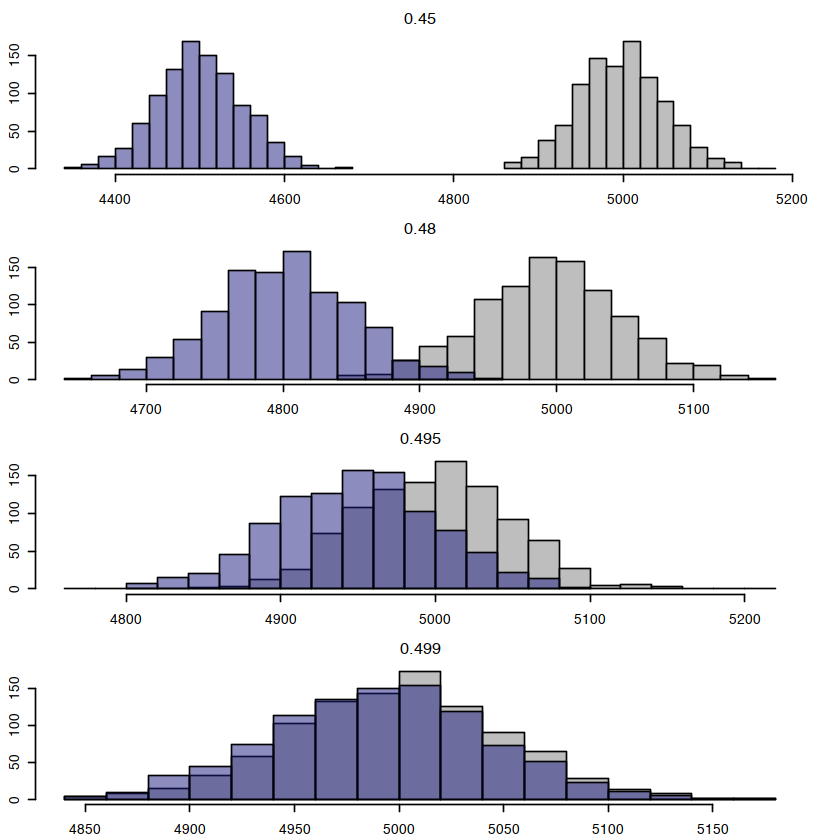

In [6]:
# Plot four histograms as above showing the identifiability of small differences in p
## par() is a confusing function that can set a variety of graphical parameters
## par( mfrow ) sets (row, column) for multi-plots
## par( mai ) sets margins
par( mfrow = c(4,1), mai=c(0.3,0.3,0.3,0.3) );
Ps = c( 0.5, 0.45, 0.48, 0.495, 0.499 );

for (i in 2:5) {
  U1 <- rbinom( n=1000, size=10000, p=0.5 ); h1 <- hist(U1,plot=FALSE, n=20);
  U2 <- rbinom( n=1000, size=10000, p=Ps[i] ); h2 <- hist(U2,plot=FALSE, n=20);

  plot( h1, xlim=c( min(h1$breaks, h2$breaks), max( h1$breaks, h2$breaks) ),
      ylim=c( min( h1$counts, h2$counts ), max( h1$counts, h2$counts ) ),
      main=Ps[i], xlab='Num heads', col='grey');
  plot( h2, add=TRUE, col=rgb(.1,.1,.5,.5) );
}

***
<img style="float: left; margin:0px 20px" src="img/question.jpg">
<B>Question 3:</B> How can you improve the distinguishability of values for $p$ close to 0.5? Do it, and include two histogram plots to prove you've made progress. One from above, with four values of $p$, and another with the same four values of $p$. What is the experimental design factor that can be manipulated here? Format your plots to look "publication quality". Save using `pdf(); ... dev.off();`.

## 4. Likelihood approaches <a id='s4'></a>

A key concept in statistics is that of likelihood. Likelihood is defined to be proportional to the probability of your observed data, $D$, given values for the model's parameters, $\theta$.

$$L(\theta; D) \propto P(D | \theta)$$

**Maximum likelihood** is a general approach to parameter estimation, in which maximum likelihood estimates (MLEs) of model parameters are obtained by choosing the parameter values that maximize the likleihood of the data at hand. That is

$$\{\hat{\theta}_\text{mle}\} = \text{argmax}_{\theta} L(\theta; D)$$

Typically because likelihoods involve computing joint probabilities of many independent observations, likelihoods involve products of many small quantities and thus become very, very small. To avoid computational difficulties with underflow, the **log-likeilhood** is therefore typically used instead of the plain likelihood.

A great deal of frequentist statistics can be derived or explained with reference to the maximum likelihood principle. This general approach to parametric inference originated with [Sir Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), one of the most important statisticians who ever lived (he was also one of the most important population geneticists of the last century). Fisher has been called "a genius who almost single-handedly created the foundations for modern statistical science".

### 4.1. Obtaining maximum likelihood solutions <a id='s41'></a>

Fundamentally, "maximum likelihood" means you try to find the values for $\theta$ that gives the highest likelihood ($\theta$ could be a scalar, for univariate problems, or a vector, for multivariate problems). As a result, there are several ways that maximum likelihood parameter estimates can be sought.

1. If the model is amenable, one can solve for the maximum of the likelihood function by setting its derivative $\frac{\partial L}{\partial \theta}$ to $0$ and solving for $\theta$ symbolically. This is typically the fastest approach computationally, but for many or even most models it can be difficult to impossible to find the desired solution analytically.
2. Particularly when there are unobserved data or hidden variables in the model, an [expectation-maximization](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm) (or EM) algorithm can be developed to rapidly maximize the likleihood (more on this approach in later weeks).
3. A numerical optimization method such as a [Quasi-Newton method](https://en.wikipedia.org/wiki/Quasi-Newton_method) can be applied, which will approximately find locally maximum likelihood solutions for any log-likelihood function. The disadvantage of these approaches is that they can be computationally slower than $1$ or $2$ since they fail to exploit special knowledge of the particular model being considered.
4. An exhaustive search or a grid search of the parameter space is also sometimes possible, which then allows the maximum likelihood solution to be obtained "directly". Exhaustive search is obviously infeasible for continuously-valued parameters and for large problems. Grid searches can approximate solutions to such problems by giving you the best value of $\theta$ that lies on a particular grid; the granularity of the grid is therefore quite important to choose carefully.

We will continue with our coin-flipping example and will begin by considering a grid search, since it is the conceptually simplest approach.

### 4.1.1. Log-likelihood function for coin-flipping

To begin, we need to consider the function we are optimizing. Look at the binomial probability distribution function above. We previously noted that since each flip is an independent trial, the order of the events is irrelevant. This means that the total number of heads obtained, $k$, and the total number of tails obtained, $N-k$, are **sufficient statistics**. This means we can throw away the list of heads and tails that preserves the order of events and we can completely represent this data as just the counts of heads and tails. This is a fairly common convenience of models involving independent trials or observations (e.g., even when the data models are complex and do not follow standard probability distributions, such as in phylogenetics; [de Koning et al., 2010](https://academic.oup.com/mbe/article/27/2/249/967476) ). Note, however, that under some different model that **did** consider the order of events (e.g., where the next outcome might depend on the previous one), $k$ and $N-k$ would no longer capture all information about the data and thus would *not* be sufficient statistics.

So, given a number of heads and tails obtained in a series of trials, we can simply calculate the log-likelihood as:

$$\begin{align}
L &= {N \choose k} p^k (1-p)^{N-k} \\
\log L &= \log {N \choose k} + k \log p + (N-k) \log(1-p)
\end{align}$$

Conveniently, `R` also has a builtin function for calculating probability under a binomial distribution, `dbinom()`.

### 4.2. Grid-search exercise <a id='s42'></a>

For a coin flipping trial of 100 flips, find the maximum likelihood value for $p$ by grid search.

[1] "MLE: " "0.47"

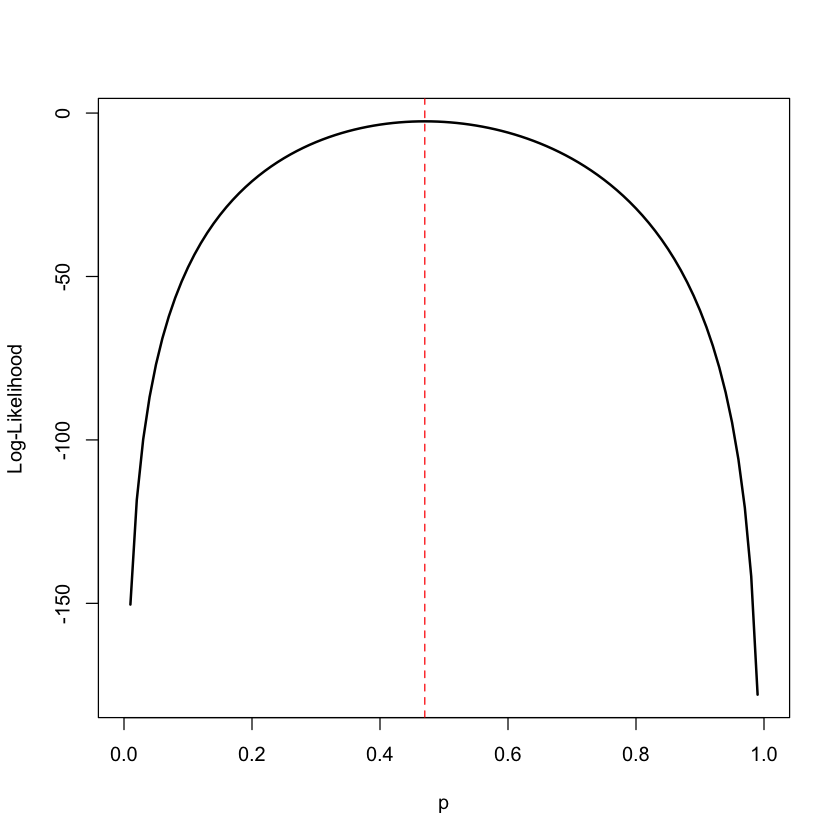

In [60]:
# Calculate log likelihood over a grid of values for p
## - dbinom() calculates the probability of observations given parameter values

# Plot the log-likelihood over diffent values of p
## seq( from, to, by ) - adjust grid granularity using `by`
## lwd=x sets line width to x

## lapply is VERY useful as a fast alternative to for loop
## Q: explain the syntax of lapply(). Why might it be preferable to using a for loop in R? (May need to dig around for this.)
nTrials <- 100;
U <- rbinom( n=1, size=nTrials, p=0.5 );

# Get x,y values for the pdf, NOTE the use of lapply()
xValues <- seq(0,1,0.01);
yValues <- unlist( lapply( xValues, function(y) log(dbinom(U,size=nTrials,p=y)) ) );

plot(xValues, yValues, type='l', ylab='Log-Likelihood', xlab='p', lwd=2);
        
# Q: What is the maximum likelihood estimate of p?
pHat <- xValues[ yValues == max( yValues )];
c("MLE: ", pHat)
                          
# Draw a dashed vertical line at the maximum
abline( v = pHat, lty='dashed', col='red' )

***
<img style="float: left; margin:0px 20px" src="img/question.jpg">
<B>Question 4:</B> Draw the likelihood surface and MLE, as above, using grid search for experiments corresponding to the conditions used for your four histograms in section 3. Save using `pdf(); ... dev.off();`. Note any problems observed.

## Example results to question 4

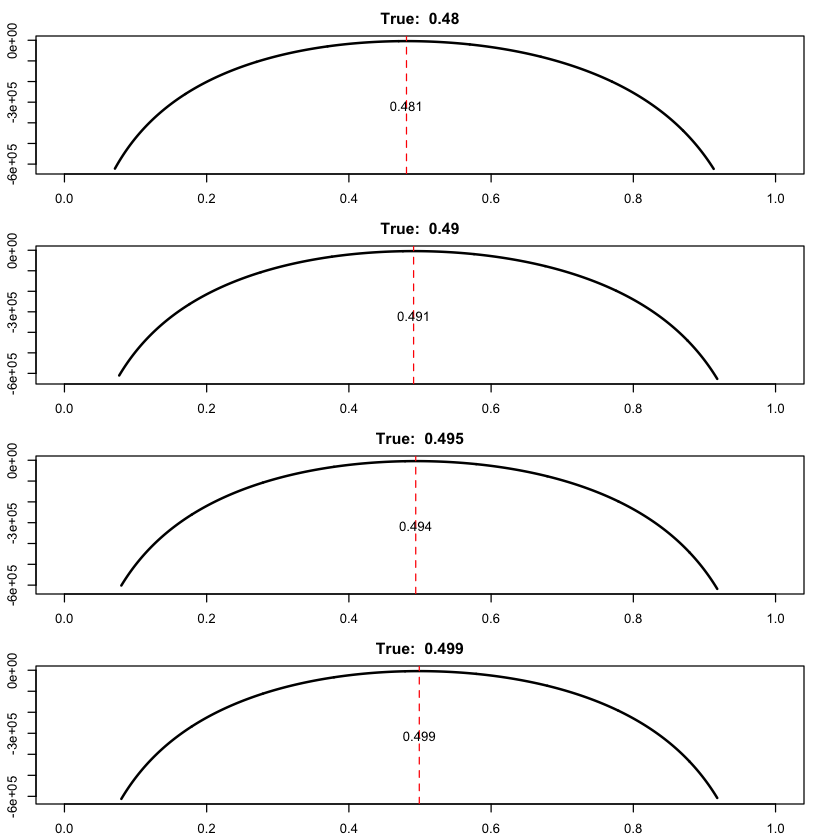

### 4.3. Numerical optimization for MLE<a id='s43'></a>

### 4.3.1. Functions in `R`

Functions in `R` can be written using the `function()` function as follows.

```
myFunction <- function( theta, k, N ) {
    result = f(x, k, n); # Your work goes here
    return(result);
}
```

***
<img style="float: left; margin:0px 20px" src="img/question.jpg">
<B>Question 5:</B> Create a `logL()` function using the above template. The function you will use below, `optim()`, expects that the first argument the function takes is the set of parameters to be optimized and the function is expected to return a scalar value. The return value should be the log-likelihood. Integrate this with the code below, which calls `optim()` and show how well your estimator performs. <B>NOTE</B> you will have to catch non-finite values in a conditional using `is.finite()`.


## Template for question 5

In [64]:
# Log-likelihood function
lnl <- function( p, numH, numTrials ) {
    return(dbinom( numH, numTrials, p));
}

# Simulate data
P=0.5; N=1000;
k = rbinom( n=1, size=N, p=P );

# Get the MLE
start=0.5; # starting value
mle = optim(start, lnl, NULL, method = "L-BFGS-B", lower=0, upper=1.0, control=list(fnscale=c(-1)), numH=k, numTrials = N);

pHat = mle$par;
maxLnL = mle$value;

print(c(mle$par, mle$value));

[1] 0.49800001 0.02522522


### General objective function optimization in `R`

`R` has a built-in function called `optim()` that can be used to minimize (or maximize) functions such as your likelihood function. Now you will write a likelihood function as above, using the log-likelihood you determined how to calculate in section 3.

`optim()` implements several numerical optimization methods and will work with any _objective function_ provided to it. We will use [`L-BFGS-b`](https://en.wikipedia.org/wiki/Limited-memory_BFGS), which is a [Quasi-Newton method](https://en.wikipedia.org/wiki/Quasi-Newton_method). The family of Newton-type hill climbing algorithms alternate between choosing a direction uphill and taking a step in that direction using a line-search. Quasi-Newton methods particularly build an approximation to the matrix of second derivatives (the "Hessian" matrix) using information collected across multiple iterations. This is much faster than calculating the full matrix of second derivatives at each step, which is required by Newton's method proper. The primary advantage of this method in our case is that it allows **bound constraints** to be enforced on the parameters being optimized. This is important since our parameter $p$ is a probability, and thus must fall in the interval $(0,1)$. 

Two final notes about `optim()` are needed. First, if you want to pass data into your objective function, simply provide the values as extra parameters in the call to `optim()` (see below). Second, by default `optim()` minimizes the objective function with respect to the parameters. To get it to maximize the function, you can set `control=list(fnscale=-1)`, which will scale the objective function $-1$ thus leading to maximization.

***

**N.B.: Numerical optimization methods typically can only guarantee to find a local optimum**. If you repeat the optimization step from a different starting point you may get a different result! **It is therefore advisable to always repeat such an analysis a couple of times,** choosing the MLE with the highest likelihood across different tries.

**N.B.: Numerical methods are not fool-proof.** Check what `optim()` parameters `maxit`, `abstol`, `reltol`, `fctr`, and `pgtol` do. If you get answers that seem wrong, try different values here.

**N.B.: Standard gradient descent/quasi-Newton methods can often fail.** For example, when the objective function may be 'bumpy'. An amazingly useful and excellent alternative approach to optimization in the in package `BB` and is called `spg` (spectral projected gradient method).

***

### 4.4. Likelihood ratios <a id='s44'></a>

Just as we can use relative likelihoods over different parameter values to find the maximum likelihood parameter estimates, the ratios of likelihoods for different choices of $\theta$ can tell us about **how well our data resolves the model.** For example, in our coin flipping model, we might infer $\hat{p}=0.49$ when the true value is $p=0.5$. But if the likelihood for these two values is nearly the same, the true value could still exist in a credible interval surrounding the MLE. 

This idea gives some intuition for the **curvature method**, which measures the curvature of the log-likelihood surface at the MLE. If the likelihood surface is highly peaked at the MLE, the data resolves the model well. If, however, the likelihood surface is relatively flat at the MLE, the data do not resolve estimates of our parameter well and we accordingly would have less confidence in the precise value of the MLE. This method is often used when performing ML inference to calculate a standard error for each parameter estimate. This involves calculating, sometimes by purely numerical methods, the second derivatives of the log-likelihood function.

As an example, we can calculate log-likelihood ratios for the same set of four $p$'s used in section 3, compared to $p=0.5$.

In [65]:
## Q: Repeat for different true value of p used in part 1
Ps = c( 0.5, 0.48, 0.49, 0.495, 0.499 );
N=10000;
LR=as.numeric();

for (i in 2:5) {
  U <- rbinom( n=1, size=N, p=Ps[i] );
  start=0.5;
  mle = optim(start, lnl, NULL, method = "L-BFGS-B", lower=0, upper=1.0, control=list(fnscale=c(-1)), numH=U, numTrials = N);
  pHat = mle$par;
  maxLnL = mle$value;
  lnLNull = lnl( 0.5, numH = U, numTrials = N );
  LR[i-1] <-  maxLnL - lnLNull ;
  
  # Print the true value of p and the LR  
  print(c(Ps[i], pHat, LR[i-1]))
}

[1] 4.800000e-01 4.999625e-01 1.244541e-09
[1] 0.490000000 0.485500039 0.007862975
[1] 0.495000000 0.492700019 0.005231046
[1] 0.49900000 0.50500003 0.00313955


***
<img style="float: left; margin:0px 20px" src="img/question.jpg">
<B>Question 6:</B> How might you determine if a likelihood ratio is "significant"? What would you get if you produced a LR distribution for data simulated under $p=0.5$?

***
<img style="float: left; margin:0px 20px" src="img/question.jpg">
<B>Question 7 (BONUS):</B> Can you come up with a better way to estimate the binomial probability $p$ by maximum likelihood (i.e., without requiring numerical optimization)? Full derivation only.